In [104]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [105]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### 중간 단계의 상태 수동 업데이트

LangGraph는 중간 단계에서 수동으로 상태를 업데이트 하는 기능을 제공하고 있습니다.  
  
상태를 업데이트하여 **에이전트의 행동을 수정하여 경로를 제어**할 수 있으며, 현재와 과거를 수정할 수 있습니다.  
  
이 기능은 **에이전트의 실수**를 수정하거나, 특정 상황에서 특정 행동을 하도록 하는 등의 행동 제어에 유용합니다.    


예를 들어,   
1. 인터넷 검색할때 잘못된 검색 쿼리로 인해 안좋은 결과를 얻을 수 있는 경우, 개입하여 쿼리 수정을 할 수 있습니다.
2. 툴 선택을 LLM 이 잘 못 선택하거나, 요건에 맞는 툴을 선택하지 않을때 개입해서 툴 선택을 제어할 수 있습니다.
3. 답변생성 과정에서 프롬프트를 조정할 수 있습니다.

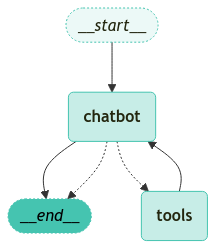

In [106]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from tools_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from graphs import visualize_graph


##### 1. 상태(State) 정의
class State(TypedDict):
    # 메모리 저장소 추가
    messages: Annotated[list, add_messages]


##### 2. 도구 정의 및 바인딩
# 도구 초기화
tool = TavilySearch()
tools = [tool]

# llm 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# llm과 도구 바인디
llm_with_tools = llm.bind_tools(tools)


##### 3. 노드 추가
# 챗봇 함수 정의, 노드 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[tool])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

##### 4. 엣지 추가
# START > chatbot
graph_builder.add_edge(START, "chatbot")

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)


##### 5. 그래프 컴파일
# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 컴파일
graph = graph_builder.compile(checkpointer=memory)

##### 6. 그래프 시각화
visualize_graph(graph)

In [107]:
from langchain_core.runnables import RunnableConfig

question = "BlockChain이 무엇인지 알려주세요! (웹검색 필수)"

input = State(messages=[("user", question)])

config = RunnableConfig(configurable={"thread_id": "1"})

채널 모곡을 출력하여 interrupt_before 와 interrupt_after 를 적용할 수 있는 목록을 확인합니다.

In [108]:
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:chatbot',
 'branch:chatbot:tools_condition:tools']

아무것도 하지않고 후출했을대 답변입니다. 아래 툴검색 결과를 변경할 것인데, 변경하고 나서와 비교하기 위한 원본입니다.

In [109]:
# 그래프 스트림 호출
events = graph.stream(
    input=input,
    config=config,
    stream_mode="values",
)

# 이벤트 반복 처리
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

BlockChain이 무엇인지 알려주세요! (웹검색 필수)
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_NRJuAllqXCYIOr0SvEdppRxy)
 Call ID: call_NRJuAllqXCYIOr0SvEdppRxy
  Args:
    query: BlockChain이란 무엇인가
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "블록체인이란 무엇인가요? 어떤 원리로 작동하나요? | NordVPN", "url": "https://nordvpn.com/ko/blog/blockchain-technology-explained/", "content": "블록체인(Blockchain)이란 정보를 기록하고 저장하는 탈중앙화 시스템입니다. 일련의 순서로 연결된 데이터 단위('블록'이라고 함)로 구성된 일종의 분산 장부 기술(Decentralized Ledger Technology)로, 각 블록에는 이전 블록의 고유 번호가 담겨 있어 체인을 형성하지요.", "score": 0.9976859, "raw_content": "주요 내용으로 건너뛰기\n왜 NordVPN인가?\n기능\n데스크톱\n모바일\n확장 프로그램\n지원 받기\n더 알아보기\n지능형 사이버 범죄 위협으로부터 비즈니스를 안전하게 보호하세요.\n가격\n지금 바로 비즈니스의 보안과 개인정보 보호를 강화하세요.\n온라인 보안 및 개인정보 보호\n비즈니스용 VPN\n안전한 비밀번호 관리자\n비즈니스 비밀번호 관리자\n암호화된 클라우드 스토리지\n왜 

In [110]:
# 그래프 스트림 호출
events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",  # interrupt_before 로 tools 노드에서 멈추게 함
)

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

BlockChain이 무엇인지 알려주세요! (웹검색 필수)
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_EtVUsQToIP348CuLeuKj3dSb)
 Call ID: call_EtVUsQToIP348CuLeuKj3dSb
  Args:
    query: 블록체인 정의


In [111]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 가장 최근 메시지 추출
last_message = snapshot.values["messages"][-1]

# 메시지 출력
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_EtVUsQToIP348CuLeuKj3dSb)
 Call ID: call_EtVUsQToIP348CuLeuKj3dSb
  Args:
    query: 블록체인 정의


#### 사람의 개입(Human-in-the-Loop)

![image.png](./image/langgraph-manual-state-update.png)

테스트를 위한 가상 웹검색 결과 추가합니다.

In [112]:
modified_search_result = """[수정된 웹 검색 결과]
    블록체인 기술은 다양한 산업 분야에서 활용되고 있으며, 그에 따라 여러 종류의 블록체인 네트워크가 존재합니다. 대표적인 블록체인 네트워크는 다음과 같습니다:
    1. 비트코인 (Bitcoin): 2009년에 사토시 나카모토라는 익명의 인물이 개발한 최초의 암호화폐이자 블록체인 네트워크입니다. 비트코인은 탈중앙화된 디지털 통화로, 중앙 기관 없이 개인 간의 거래를 가능하게 합니다.
    2. 이더리움 (Ethereum): 2015년에 비탈릭 부테린이 개발한 블록체인 플랫폼으로, 스마트 계약 기능을 통해 다양한 분산 애플리케이션(DApp)을 구축할 수 있습니다. 이더리움은 암호화폐인 이더(ETH)를 사용하며, 금융, 게임, 예술 등 다양한 분야에서 활용되고 있습니다.
    3. 리플 (Ripple): 리플은 금융 기관 간의 국제 송금을 빠르고 저렴하게 처리하기 위해 개발된 블록체인 기반의 결제 프로토콜입니다. 리플의 네이티브 암호화폐인 XRP를 활용하여 거래 속도를 높이고 비용을 절감할 수 있습니다.
    4. 하이퍼레저 (Hyperledger): 리눅스 재단이 주도하는 오픈 소스 블록체인 프로젝트로, 기업용 블록체인 솔루션을 개발하기 위한 플랫폼입니다. 하이퍼레저는 모듈식 아키텍처를 통해 다양한 산업 분야에서 맞춤형 블록체인 네트워크를 구축할 수 있도록 지원합니다.
    5. EOS: 이더리움과 유사하게 스마트 계약 및 DApp 개발을 지원하는 블록체인 플랫폼으로, 높은 처리 속도와 확장성을 강조합니다. EOS는 지분 증명(Proof of Stake) 합의 알고리즘을 사용하여 거래 속도를 향상시킵니다.
    이 외에도 카르다노(Cardano), 솔라나(Solana), 폴카닷(Polkadot) 등 다양한 블록체인 네트워크가 존재하며, 각기 다른 특징과 활용 사례를 가지고 있습니다.
"""

print(modified_search_result)

[수정된 웹 검색 결과]
    블록체인 기술은 다양한 산업 분야에서 활용되고 있으며, 그에 따라 여러 종류의 블록체인 네트워크가 존재합니다. 대표적인 블록체인 네트워크는 다음과 같습니다:
    1. 비트코인 (Bitcoin): 2009년에 사토시 나카모토라는 익명의 인물이 개발한 최초의 암호화폐이자 블록체인 네트워크입니다. 비트코인은 탈중앙화된 디지털 통화로, 중앙 기관 없이 개인 간의 거래를 가능하게 합니다.
    2. 이더리움 (Ethereum): 2015년에 비탈릭 부테린이 개발한 블록체인 플랫폼으로, 스마트 계약 기능을 통해 다양한 분산 애플리케이션(DApp)을 구축할 수 있습니다. 이더리움은 암호화폐인 이더(ETH)를 사용하며, 금융, 게임, 예술 등 다양한 분야에서 활용되고 있습니다.
    3. 리플 (Ripple): 리플은 금융 기관 간의 국제 송금을 빠르고 저렴하게 처리하기 위해 개발된 블록체인 기반의 결제 프로토콜입니다. 리플의 네이티브 암호화폐인 XRP를 활용하여 거래 속도를 높이고 비용을 절감할 수 있습니다.
    4. 하이퍼레저 (Hyperledger): 리눅스 재단이 주도하는 오픈 소스 블록체인 프로젝트로, 기업용 블록체인 솔루션을 개발하기 위한 플랫폼입니다. 하이퍼레저는 모듈식 아키텍처를 통해 다양한 산업 분야에서 맞춤형 블록체인 네트워크를 구축할 수 있도록 지원합니다.
    5. EOS: 이더리움과 유사하게 스마트 계약 및 DApp 개발을 지원하는 블록체인 플랫폼으로, 높은 처리 속도와 확장성을 강조합니다. EOS는 지분 증명(Proof of Stake) 합의 알고리즘을 사용하여 거래 속도를 향상시킵니다.
    이 외에도 카르다노(Cardano), 솔라나(Solana), 폴카닷(Polkadot) 등 다양한 블록체인 네트워크가 존재하며, 각기 다른 특징과 활용 사례를 가지고 있습니다.



내가 만든 메시지로 검색결과를 바꾸려면 tool_call_id를 추출해야 합니다.

In [113]:
# 수정하고자 하는 `ToolMessage` 의 `tool_call_id` 추출
tool_call_id = last_message.tool_calls[0]["id"]
print(tool_call_id)

call_EtVUsQToIP348CuLeuKj3dSb


아래 코드를 실행하면 ToolMessage 가 변경된 것을 확인할 수 있습니다.

In [114]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [
    # LLM API의 도구 호출과 일치하는 ToolMessage 필요
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id,
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과]
    블록체인 기술은 다양한 산업 분야에서 활용되고 있으며, 그에 따라 여러 종류의 블록체인 네트워크가 존재합니다. 대표적인 블록체인 네트워크는 다음과 같습니다:
    1. 비트코인 (Bitcoin): 2009년에 사토시 나카모토라는 익명의 인물이 개발한 최초의 암호화폐이자 블록체인 네트워크입니다. 비트코인은 탈중앙화된 디지털 통화로, 중앙 기관 없이 개인 간의 거래를 가능하게 합니다.
    2. 이더리움 (Ethereum): 2015년에 비탈릭 부테린이 개발한 블록체인 플랫폼으로, 스마트 계약 기능을 통해 다양한 분산 애플리케이션(DApp)을 구축할 수 있습니다. 이더리움은 암호화폐인 이더(ETH)를 사용하며, 금융, 게임, 예술 등 다양한 분야에서 활용되고 있습니다.
    3. 리플 (Ripple): 리플은 금융 기관 간의 국제 송금을 빠르고 저렴하게 처리하기 위해 개발된 블록체인 기반의 결제 프로토콜입니다. 리플의 네이티브 암호화폐인 XRP를 활용하여 거래 속도를 높이고 비용을 절감할 수 있습니다.
    4. 하이퍼레저 (Hyperledger): 리눅스 재단이 주도하는 오픈 소스 블록체인 프로젝트로, 기업용 블록체인 솔루션을 개발하기 위한 플랫폼입니다. 하이퍼레저는 모듈식 아키텍처를 통해 다양한 산업 분야에서 맞춤형 블록체인 네트워크를 구축할 수 있도록 지원합니다.
    5. EOS: 이더리움과 유사하게 스마트 계약 및 DApp 개발을 지원하는 블록체인 플랫폼으로, 높은 처리 속도와 확장성을 강조합니다. EOS는 지분 증명(Proof of Stake) 합의 알고리즘을 사용하여 거래 속도를 향상시킵니다.
    이 외에도 카르다노(Cardano), 솔라나(Solana), 폴카닷(Polkadot) 등 다양한 블록체인 네트워크가 존재하며, 각기 다른 특징과 활용 사례를 가지고 있습

#### StateGraph의 `update_state` 메서드

`update_state()` 메서드는 LangGraph에서 상태를 수동으로 업데이트할 때 사용하는 중요한 메서드입니다. 주요 특징을 설명하면:

**매개변수**

- config (RunnableConfig): 실행 구성
- values (Optional[Union[dict[str, Any], Any]]): 업데이트할 값들
- as_node (Optional[str]): 값의 출처로 간주할 노드 이름. 기본값은 None

**주요기능**

- 체크포인터를 통해 이전 상태를 로드하고 새로운 상태를 저장합니다.
- 서브그래프에 대한 상태 업데이트를 처리합니다.
- `as_node`가 지정되지 않은 경우, 마지막으로 상태를 업데이트한 노드를 찾습니다.
- 지정된 노드의 writer들을 실행하여 상태를 업데이트합니다.
- 업데이트된 상태를 체크포인트에 저장합니다.

**주요로직**

- 체크포인터를 확인하고, 없으면 ValueError를 발생시킵니다.
- 서브그래프에 대한 업데이트인 경우, 해당 서브그래프의 update_state 메서드를 호출합니다.
- 이전 체크포인트를 로드하고, 필요한 경우 as_node를 결정합니다.
- 지정된 노드의 writer들을 사용하여 상태를 업데이트합니다.
- 업데이트된 상태를 새로운 체크포인트로 저장합니다.

**참고**

- 이 메서드는 그래프의 상태를 수동으로 업데이트할 때 사용됩니다.
- 체크포인터를 사용하여 상태의 버전 관리와 지속성을 보장합니다.
- as_node를 지정하지 않으면 자동으로 결정되지만, 모호한 경우 오류가 발생할 수 있습니다.
- 상태 업데이트 중 SharedValues에 쓰기 작업은 허용되지 않습니다.


In [115]:
graph.update_state(config, {"messages": new_messages}, as_node="tools")

print(graph.get_state(config).values["messages"][-1])

content='[수정된 웹 검색 결과]\n    블록체인 기술은 다양한 산업 분야에서 활용되고 있으며, 그에 따라 여러 종류의 블록체인 네트워크가 존재합니다. 대표적인 블록체인 네트워크는 다음과 같습니다:\n    1. 비트코인 (Bitcoin): 2009년에 사토시 나카모토라는 익명의 인물이 개발한 최초의 암호화폐이자 블록체인 네트워크입니다. 비트코인은 탈중앙화된 디지털 통화로, 중앙 기관 없이 개인 간의 거래를 가능하게 합니다.\n    2. 이더리움 (Ethereum): 2015년에 비탈릭 부테린이 개발한 블록체인 플랫폼으로, 스마트 계약 기능을 통해 다양한 분산 애플리케이션(DApp)을 구축할 수 있습니다. 이더리움은 암호화폐인 이더(ETH)를 사용하며, 금융, 게임, 예술 등 다양한 분야에서 활용되고 있습니다.\n    3. 리플 (Ripple): 리플은 금융 기관 간의 국제 송금을 빠르고 저렴하게 처리하기 위해 개발된 블록체인 기반의 결제 프로토콜입니다. 리플의 네이티브 암호화폐인 XRP를 활용하여 거래 속도를 높이고 비용을 절감할 수 있습니다.\n    4. 하이퍼레저 (Hyperledger): 리눅스 재단이 주도하는 오픈 소스 블록체인 프로젝트로, 기업용 블록체인 솔루션을 개발하기 위한 플랫폼입니다. 하이퍼레저는 모듈식 아키텍처를 통해 다양한 산업 분야에서 맞춤형 블록체인 네트워크를 구축할 수 있도록 지원합니다.\n    5. EOS: 이더리움과 유사하게 스마트 계약 및 DApp 개발을 지원하는 블록체인 플랫폼으로, 높은 처리 속도와 확장성을 강조합니다. EOS는 지분 증명(Proof of Stake) 합의 알고리즘을 사용하여 거래 속도를 향상시킵니다.\n    이 외에도 카르다노(Cardano), 솔라나(Solana), 폴카닷(Polkadot) 등 다양한 블록체인 네트워크가 존재하며, 각기 다른 특징과 활용 사례를 가지고 있습니다.\n' id='d8f910fc-2b9d-4cc9-bcfb-233b059b3c58' tool_call_id='cal

지금까지, 
1. tools 를 사용하기 전에 interrupt_before 를 사용하여 멈추게 했습니다. 
2. tool_call_id 를 추출하여 수정된 검색결과를 추가하였습니다.
3. 수정된 검색결과를 추가하기 위해 update_state 를 사용하여 상태를 수동으로 업데이트 했습니다.

다음차례는 chatbot 노드가 호출되어 수정된 검색결과를 사용하여 답변을 생성하는 것입니다.

In [116]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [117]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과]
    블록체인 기술은 다양한 산업 분야에서 활용되고 있으며, 그에 따라 여러 종류의 블록체인 네트워크가 존재합니다. 대표적인 블록체인 네트워크는 다음과 같습니다:
    1. 비트코인 (Bitcoin): 2009년에 사토시 나카모토라는 익명의 인물이 개발한 최초의 암호화폐이자 블록체인 네트워크입니다. 비트코인은 탈중앙화된 디지털 통화로, 중앙 기관 없이 개인 간의 거래를 가능하게 합니다.
    2. 이더리움 (Ethereum): 2015년에 비탈릭 부테린이 개발한 블록체인 플랫폼으로, 스마트 계약 기능을 통해 다양한 분산 애플리케이션(DApp)을 구축할 수 있습니다. 이더리움은 암호화폐인 이더(ETH)를 사용하며, 금융, 게임, 예술 등 다양한 분야에서 활용되고 있습니다.
    3. 리플 (Ripple): 리플은 금융 기관 간의 국제 송금을 빠르고 저렴하게 처리하기 위해 개발된 블록체인 기반의 결제 프로토콜입니다. 리플의 네이티브 암호화폐인 XRP를 활용하여 거래 속도를 높이고 비용을 절감할 수 있습니다.
    4. 하이퍼레저 (Hyperledger): 리눅스 재단이 주도하는 오픈 소스 블록체인 프로젝트로, 기업용 블록체인 솔루션을 개발하기 위한 플랫폼입니다. 하이퍼레저는 모듈식 아키텍처를 통해 다양한 산업 분야에서 맞춤형 블록체인 네트워크를 구축할 수 있도록 지원합니다.
    5. EOS: 이더리움과 유사하게 스마트 계약 및 DApp 개발을 지원하는 블록체인 플랫폼으로, 높은 처리 속도와 확장성을 강조합니다. EOS는 지분 증명(Proof of Stake) 합의 알고리즘을 사용하여 거래 속도를 향상시킵니다.
    이 외에도 카르다노(Cardano), 솔라나(Solana), 폴카닷(Polkadot) 등 다양한 블록체인 네트워크가 존재하며, 각기 다른 특징과 활용 사례를 가지고 있습

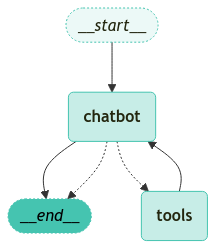

In [118]:
visualize_graph(graph)

현재 상태를 이전과 같이 점검합니다. 체크포인트가 수동 업데이트를 반영하는지 확인합니다.

In [119]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

BlockChain이 무엇인지 알려주세요! (웹검색 필수)
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_NRJuAllqXCYIOr0SvEdppRxy)
 Call ID: call_NRJuAllqXCYIOr0SvEdppRxy
  Args:
    query: BlockChain이란 무엇인가
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "블록체인이란 무엇인가요? 어떤 원리로 작동하나요? | NordVPN", "url": "https://nordvpn.com/ko/blog/blockchain-technology-explained/", "content": "블록체인(Blockchain)이란 정보를 기록하고 저장하는 탈중앙화 시스템입니다. 일련의 순서로 연결된 데이터 단위('블록'이라고 함)로 구성된 일종의 분산 장부 기술(Decentralized Ledger Technology)로, 각 블록에는 이전 블록의 고유 번호가 담겨 있어 체인을 형성하지요.", "score": 0.9976859, "raw_content": "주요 내용으로 건너뛰기\n왜 NordVPN인가?\n기능\n데스크톱\n모바일\n확장 프로그램\n지원 받기\n더 알아보기\n지능형 사이버 범죄 위협으로부터 비즈니스를 안전하게 보호하세요.\n가격\n지금 바로 비즈니스의 보안과 개인정보 보호를 강화하세요.\n온라인 보안 및 개인정보 보호\n비즈니스용 VPN\n안전한 비밀번호 관리자\n비즈니스 비밀번호 관리자\n암호화된 클라우드 스토리지\n왜 

In [120]:
# 다음 상태 출력
print(snapshot.next)

()


#### Interrupt 후 메시지 상태 업데이트 - 이어서 진행

상태 수정을 하기 위해 다음 노드로 진행하기 전 interrupt 를 발생시켜 중단하고, 상태를 갱신한 뒤 이어서 진행하는 방법입니다.  
  
위의 메모리와 공유되지 않기 위해 새로운 `thread_id` 를 생성합니다.  
  
여기서는 랜덤한 해시값을 생성하는 직접 작성한 `generate_random_hash` 함수를 사용합니다.


##### 1. 인터럽트를 실행합니다.

In [121]:
from graphs import generate_random_hash

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

question = "블록체인 기술에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# 새로운 config 생성
config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

thread_id: a772aa
================================ Human Message =================================

블록체인 기술에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_V4WgLFZ9YTrZHrCM1GYXYToX)
 Call ID: call_V4WgLFZ9YTrZHrCM1GYXYToX
  Args:
    query: 블록체인 기술 자료 추천


다음으로, 에이전트를 위한 도구 호출을 업데이트 합니다.  
  
##### 2. Message ID 를 가져옵니다.

In [122]:
from langchain_core.messages import AIMessage

# 마지막 메시지를 가져옵니다.
snapshot = graph.get_state(config)

# messages 의 마지막 메시지 가져오기
existing_message = snapshot.values["messages"][-1]

# 메시지 ID 출력
print("Message ID:", existing_message.id)

Message ID: run-180949cd-9e94-4b61-83de-d2cbc19625c6-0


마지막 메시지는 `tavily_search` 라는 도구를 호출 정보를 가지고 있는 메시지입니다. AI Message 입니다.  

```str
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_9zfnj9JH3lruDGaZ682OrSQy)
 Call ID: call_9zfnj9JH3lruDGaZ682OrSQy
  Args:
    query: 블록체인 기술 자료 추천
Message ID: run-27d086c0-4705-42fb-bae8-cf632443690c-0
````

##### 3. existing_message에 tool_call() 메서드를 사용하여 주요 속성들을 추출합니다.  
  
**주요 속성**
- `id`: 도구 호출의 고유 ID
- `name`: 도구 이름
- `args`: 도구 호출에 전달된 인수
- `call_id`: 도구 호출의 고유 ID

In [123]:
# 첫번째 도구 호출 출력
print(existing_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': '블록체인 기술 자료 추천'}, 'id': 'call_V4WgLFZ9YTrZHrCM1GYXYToX', 'type': 'tool_call'}


##### 4. 위의 속성 값 중 `args` 의 `query` 값을 수정합니다.

In [124]:
# tool_calls 를 복사하여 새로운 도구 호출 생성
new_tool_call = existing_message.tool_calls[0].copy()

# 쿼리 매개변수 업데이트(갱신)
new_tool_call["args"] = {"query": "디파이 투자 관련 자료 추천"}

# 업데이트된 도구 호출 출력
print(new_tool_call)

{'name': 'tavily_web_search', 'args': {'query': '디파이 투자 관련 자료 추천'}, 'id': 'call_V4WgLFZ9YTrZHrCM1GYXYToX', 'type': 'tool_call'}


##### 5. 마지막 메시지를 수정합니다.

In [125]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    id=existing_message.id,
)

print(new_message.id)

# 업데이트된 메시지 출력
new_message.pretty_print()

run-180949cd-9e94-4b61-83de-d2cbc19625c6-0
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_V4WgLFZ9YTrZHrCM1GYXYToX)
 Call ID: call_V4WgLFZ9YTrZHrCM1GYXYToX
  Args:
    query: 디파이 투자 관련 자료 추천


검색 쿼리가 업데이트 되었습니다.  
  
##### 6. 업데이트된 도구를 호출합니다.

In [126]:
# 업데이트된 도구 호출 출력
print(new_message.tool_calls[0])

# 메시지 ID 출력
print("\nMessage ID", new_message.id)

# 그래프 상태 업데이트
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_web_search', 'args': {'query': '디파이 투자 관련 자료 추천'}, 'id': 'call_V4WgLFZ9YTrZHrCM1GYXYToX', 'type': 'tool_call'}

Message ID run-180949cd-9e94-4b61-83de-d2cbc19625c6-0


{'configurable': {'thread_id': 'a772aa',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb8fb9-d0da-692e-8002-d6843840503c'}}

그래프에도 업데이트 하였기 때문에 그래프의 상태값도 확인해봅니다.

In [127]:
# 마지막 메시지의 도구 호출 가져오기
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': '디파이 투자 관련 자료 추천'},
  'id': 'call_V4WgLFZ9YTrZHrCM1GYXYToX',
  'type': 'tool_call'}]

##### 7. 기존 설정과 None 입력을 사용하여 그래프 이어서 스트리밍 합니다.

In [128]:
# 그래프 스트림에서 이벤트 수신
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_V4WgLFZ9YTrZHrCM1GYXYToX)
 Call ID: call_V4WgLFZ9YTrZHrCM1GYXYToX
  Args:
    query: 디파이 투자 관련 자료 추천
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "탈중앙화 금융 | 디파이 (DeFi) 뜻과 사용하는 법, 투자 가이드", "url": "https://moneyrich.kr/blog/탈중앙화-금융-디파이defi-뜻과-사용하는-법-투자/", "content": "꿀팁 3: 분산 투자, 안전하게 수익률 높이는 지름길! ... Tag : 디파이. 디파이 관련 동영상. 로그인 후 디파이에 대한 FAQ를 등록해 주세요. 관련자료. 댓글 0. 등록된 댓글이 없습니다. 로그인한 회원만 댓글 등록이 가능합니다. 목록", "score": 0.9978258, "raw_content": null}, {"title": "디파이(DeFi)란? 탈중앙화 금융의 개념과 투자 방법", "url": "https://nomadcareer.kr/blog/디파이defi란-탈중앙화-금융의-개념과-투자-방법/", "content": "디파이 투자 방법과 주의사항. 디파이에 투자하는 방법은 크게 대출, 스테이킹, 유동성 공급 등의 서비스에 자산을 예치하거나, 디파이 토큰에 투자하는 방식으로 나눌 수 있습니다. 1. 투자 방법. 디파이 대출 플랫폼에 자산을 예치하고 이자를 받는 방식.", "score": 0.99401975, "raw_content": "\n\n\t\t\t\t\t\t\t\t로그인\n\t\t\t\t\t\t\t\n\n\n\t\t\t\t\t\t\

In [129]:
# 이벤트 스트림 생성
events = graph.stream(
    {
        "messages": (
            "user",
            "내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!",
        )
    },
    config,
    stream_mode="values",
)

# 메시지 이벤트 처리
for event in events:
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!
================================== Ai Message ==================================

블록체인 기술에 대해 배운 내용을 정리해 드리겠습니다.

1. **블록체인 기술의 기본 개념**:
   - 블록체인은 데이터를 안전하게 저장하고 관리하는 분산 원장 기술입니다. 이 기술은 중앙 기관 없이도 거래를 기록하고 검증할 수 있게 해줍니다. 모든 거래는 블록에 기록되고, 이 블록들은 체인 형태로 연결되어 있어 데이터의 무결성을 보장합니다.

2. **탈중앙화 금융(DeFi)**:
   - 디파이는 "탈중앙화 금융(Decentralized Finance)"의 약자로, 기존의 중앙화된 금융 시스템을 벗어나 블록체인 기술을 통해 금융 서비스를 제공하는 것을 의미합니다. 디파이는 주로 이더리움 블록체인 위에서 작동하며, 스마트 계약을 통해 자동화된 금융 거래가 이루어집니다. 이를 통해 대출, 투자, 송금 등의 금융 활동을 중앙 기관 없이도 가능하게 합니다.

3. **디파이의 주요 특징**:
   - **탈중앙화**: 중앙 기관 없이 개인 간의 직접 거래가 이루어집니다.
   - **투명성**: 모든 거래는 블록체인에 기록되어 누구나 조회할 수 있습니다.
   - **스마트 계약**: 미리 설정된 조건에 따라 자동으로 계약이 실행되는 프로그램으로, 중개자 없이도 거래가 이루어집니다.

4. **디파이 투자 방법**:
   - 디파이에 투자하는 방법은 크게 대출, 스테이킹, 유동성 공급 등의 서비스에 자산을 예치하거나, 디파이 토큰에 투자하는 방식으로 나눌 수 있습니다. 예를 들어, 디파이 플랫폼에 자산을 예치하고 이자를 받거나, 스테이킹을 통해 보상을 받을 수 있습니다.

In [130]:
# 마지막 최종 메시지 확인
graph.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================

블록체인 기술에 대해 배운 내용을 정리해 드리겠습니다.

1. **블록체인 기술의 기본 개념**:
   - 블록체인은 데이터를 안전하게 저장하고 관리하는 분산 원장 기술입니다. 이 기술은 중앙 기관 없이도 거래를 기록하고 검증할 수 있게 해줍니다. 모든 거래는 블록에 기록되고, 이 블록들은 체인 형태로 연결되어 있어 데이터의 무결성을 보장합니다.

2. **탈중앙화 금융(DeFi)**:
   - 디파이는 "탈중앙화 금융(Decentralized Finance)"의 약자로, 기존의 중앙화된 금융 시스템을 벗어나 블록체인 기술을 통해 금융 서비스를 제공하는 것을 의미합니다. 디파이는 주로 이더리움 블록체인 위에서 작동하며, 스마트 계약을 통해 자동화된 금융 거래가 이루어집니다. 이를 통해 대출, 투자, 송금 등의 금융 활동을 중앙 기관 없이도 가능하게 합니다.

3. **디파이의 주요 특징**:
   - **탈중앙화**: 중앙 기관 없이 개인 간의 직접 거래가 이루어집니다.
   - **투명성**: 모든 거래는 블록체인에 기록되어 누구나 조회할 수 있습니다.
   - **스마트 계약**: 미리 설정된 조건에 따라 자동으로 계약이 실행되는 프로그램으로, 중개자 없이도 거래가 이루어집니다.

4. **디파이 투자 방법**:
   - 디파이에 투자하는 방법은 크게 대출, 스테이킹, 유동성 공급 등의 서비스에 자산을 예치하거나, 디파이 토큰에 투자하는 방식으로 나눌 수 있습니다. 예를 들어, 디파이 플랫폼에 자산을 예치하고 이자를 받거나, 스테이킹을 통해 보상을 받을 수 있습니다.

5. **리스크 관리**:
   - 디파이는 높은 수익을 제공할 수 있지만, 그만큼 리스크도 큽니다. 자산이 스마트 계약을 통해 운영되기 때문에 보안 취약성이나 해킹의 위험이 있으며, 암호화폐 가격 변동성이 커서 손실 위험도 존재합니다. 따라서 신

#### 지난 스냅샷의 결과 수정 및 Replay

지난 스냅샷의 결과를 수정하여 Replay 하는 방법입니다.  
  
지난 스냅샷을 확인 후 특정 노드로 되돌아가 상태를 수정한 후 해당 노드부터 다시 진행합니다.  
  
이를 Replay 이라고 합니다.  

##### 1. 지난 스냅샷을 가져옵니다.

In [131]:
to_replay_state = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        print(state.values["messages"][-1].id)
        # 메시지 수 및 다음 상태 출력
        print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
        print("-" * 80)
        # 특정 상태 선택 기준: 채팅 메시지 수
        if len(state.values["messages"]) == 2:
            # 특정 메시지 ID 선택
            to_replay_state = state

run-e2674a85-594a-463e-9b84-fab6d9c4e8e8-0
메시지 수:  6 다음 노드:  ()
--------------------------------------------------------------------------------
78eaba40-9270-4316-8bcb-7cf782ec9695
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-20a8c483-f371-4068-b348-8df13eddb0aa-0
메시지 수:  4 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------
run-20a8c483-f371-4068-b348-8df13eddb0aa-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
b51dab41-3a75-4fcf-91d1-b2980b9a3221
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-180949cd-9e94-4b61-83de-d2cbc19625c6-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run-180949cd-9e94-4b61-83de-d2cbc19625c6-0
메시지 수:  2 다음 노드:  ('tools',)
------------------------------

##### 2. 선택한 메시지의 내용을 확인합니다.

In [132]:
from langchain_print import display_message_tree

# 선택한 메시지 가져오기
existing_message = to_replay_state.values["messages"][-1]

# 메시지 트리 출력
display_message_tree(existing_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_V4WgLFZ9YTrZHrCM1GYXYToX"
                function:
                    arguments: "{"query":"블록체인 기술 자료 추천"}"
                    name: "tavily_web_search"
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 23
            prompt_tokens: 113
            total_tokens: 136
            completion_tokens_details:
                accepted_prediction_tokens: 0
                audio_tokens: 0
                reasoning_tokens: 0
                rejected_prediction_tokens: 0
            prompt_tokens_details:
                audio_tokens: 0
                cached_tokens: 0
        model_name: "gpt-4o-mini-2024-07-18"
        system_fingerprint: "fp_6fc10e10eb"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run-180949cd-9e94-4b61-83de-d2cbc19625c6-0"
    example:

##### 3. 검색 쿼리 업데이트 한 tool_call 을 생성합니다.

In [133]:
tool_call = existing_message.tool_calls[0].copy()

tool_call["args"]["query"] = "디파이 투자 관련 자료 추천"

# 업데이트된 도구 호출 출력
print(tool_call)

{'name': 'tavily_web_search', 'args': {'query': '디파이 투자 관련 자료 추천'}, 'id': 'call_V4WgLFZ9YTrZHrCM1GYXYToX', 'type': 'tool_call'}


##### 4. 업데이트된 도구 호출을 사용하여 새로운 AIMessage를 생성합니다.

In [134]:
# 새로운 AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[tool_call],
    id=existing_message.id,
)

# 업데이트된 메시지 출력
new_message.pretty_print()

new_message.tool_calls[0]["args"]

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_V4WgLFZ9YTrZHrCM1GYXYToX)
 Call ID: call_V4WgLFZ9YTrZHrCM1GYXYToX
  Args:
    query: 디파이 투자 관련 자료 추천


{'query': '디파이 투자 관련 자료 추천'}

아래는 업데이트가 되기 전의 메시지 입니다.

In [135]:
# 업데이터 전 메시지 확인
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': '블록체인 기술 자료 추천'},
  'id': 'call_V4WgLFZ9YTrZHrCM1GYXYToX',
  'type': 'tool_call'}]

##### 5. 업데이트된 메시지를 그래프에 적용합니다.


In [136]:
updated_state = graph.update_state(to_replay_state.config, {"messages": [new_message]})

# 업데이트된 메시지 확인
print(updated_state)
print(graph.get_state(config).values["messages"][-1])

{'configurable': {'thread_id': 'a772aa', 'checkpoint_ns': '', 'checkpoint_id': '1efb8fbb-3408-6f0e-8002-dd88618841a4'}}
content='' additional_kwargs={} response_metadata={} id='run-180949cd-9e94-4b61-83de-d2cbc19625c6-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '디파이 투자 관련 자료 추천'}, 'id': 'call_V4WgLFZ9YTrZHrCM1GYXYToX', 'type': 'tool_call'}]


##### 6. 업데이트 된 상태를 스트리밍 합니다.

In [137]:
# config 에는 updated_state 를 전달합니다. 이는 임의로 갱신한 상태를 전달하는 것입니다.
for event in graph.stream(None, updated_state, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_V4WgLFZ9YTrZHrCM1GYXYToX)
 Call ID: call_V4WgLFZ9YTrZHrCM1GYXYToX
  Args:
    query: 디파이 투자 관련 자료 추천
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "디파이(DeFi)란? 탈중앙화 금융의 개념과 투자 방법", "url": "https://nomadcareer.kr/blog/디파이defi란-탈중앙화-금융의-개념과-투자-방법/", "content": "디파이 투자 방법과 주의사항. 디파이에 투자하는 방법은 크게 대출, 스테이킹, 유동성 공급 등의 서비스에 자산을 예치하거나, 디파이 토큰에 투자하는 방식으로 나눌 수 있습니다. 1. 투자 방법. 디파이 대출 플랫폼에 자산을 예치하고 이자를 받는 방식.", "score": 0.9940659, "raw_content": null}, {"title": "디파이(DeFi)란 무엇인가? 의미와 활용 방법, 투자 전략 알아보기", "url": "https://dreamyo.kr/contents/디파이defi란-무엇인가-의미와-활용-방법-투자-전략-알아보기/", "content": "관련 키워드. 탈중앙화 금융 스마트컨트랙트 암호화폐 예치 스테이킹 . 디파이(DeFi)는 기존 금융 시스템과는 달리 탈중앙화된 금융 서비스를 제공하며 개인에게 더 많은 투자 기회와 수익 창출의 가능성을 제공합니다. 다양한 디파이 플랫폼과 서비스를 통해", "score": 0.98975134, "raw_content": null}, {"title": "디파이(Defi) 총정리 (뜻, 대출, 유동성공급, 스

##### 최종 결과를 출력합니다.

In [138]:
# 최종 결과 출력
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

블록체인 기술에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_V4WgLFZ9YTrZHrCM1GYXYToX)
 Call ID: call_V4WgLFZ9YTrZHrCM1GYXYToX
  Args:
    query: 디파이 투자 관련 자료 추천
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "디파이(DeFi)란? 탈중앙화 금융의 개념과 투자 방법", "url": "https://nomadcareer.kr/blog/디파이defi란-탈중앙화-금융의-개념과-투자-방법/", "content": "디파이 투자 방법과 주의사항. 디파이에 투자하는 방법은 크게 대출, 스테이킹, 유동성 공급 등의 서비스에 자산을 예치하거나, 디파이 토큰에 투자하는 방식으로 나눌 수 있습니다. 1. 투자 방법. 디파이 대출 플랫폼에 자산을 예치하고 이자를 받는 방식.", "score": 0.9940659, "raw_content": null}, {"title": "디파이(DeFi)란 무엇인가? 의미와 활용 방법, 투자 전략 알아보기", "url": "https://dreamyo.kr/contents/디파이defi란-무엇인가-의미와-활용-방법-투자-전략-알아보기/", "content": "관련 키워드. 탈중앙화 금융 스마트컨트랙트 암호화폐 예치 스테이킹 . 디파이(DeFi)는 기존 금융 시스템과는 달리 탈중앙화된 금융 서비스를 제공하며 개인에게 더 많은 투자 기회와 수익 